In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import json 
base_dir = 'results\\hold_out_set_and_predicted_faults\\'
import pickle
from sklearn.metrics import precision_recall_curve, auc,confusion_matrix
import json
import joblib
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # for 3D scatter plot

In [2]:
def load_data(file_name):
    df = pd.read_csv(base_dir+file_name, index_col='Datetime')
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    return df
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_silhouette(X, max_clusters=10, subsample_size=None):
    """
    Plots the elbow method and silhouette score for selecting the number of clusters for k-means clustering.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - max_clusters: Maximum number of clusters to consider (default is 10)
    - subsample_size: Size of the subsample for silhouette score calculation (default is None, meaning no subsampling)
    """
    # Elbow Method
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Silhouette Score
    silhouette_scores = []
    if subsample_size is not None and subsample_size < len(X):
        indices = np.random.choice(len(X), size=subsample_size, replace=False)
        X_subsample = X[indices]
    else:
        X_subsample = X

    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        cluster_labels = kmeans.fit_predict(X_subsample)
        silhouette_scores.append(silhouette_score(X_subsample, cluster_labels))
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"The optimal number of based on Silhouette score clusters is: {optimal_clusters}")
    # Plot Elbow Method
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

from sklearn.metrics import silhouette_score

def train_and_fine_tune_kmeans(data, num_clusters, max_iterations=300, random_state=42):
    """
    Train and fine-tune a KMeans model with a specified number of clusters.

    Parameters:
    - data: array-like
        The training data for clustering.
    - num_clusters: int
        The number of clusters to create.
    - max_iterations: int, optional (default=300)
        Maximum number of iterations for the KMeans algorithm.
    - random_state: int, optional (default=42)
        Random seed for reproducibility.

    Returns:
    - trained_kmeans: KMeans
        The trained KMeans model.
    """

    # Initialize KMeans model with the specified number of clusters
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations, random_state=random_state)

    # Fit the KMeans model to the training data
    kmeans.fit(data)

    # Fine-tune the model based on silhouette score
    silhouette_scores = []
    for n_clusters in range(2, num_clusters + 1):
        kmeans_temp = KMeans(n_clusters=n_clusters, max_iter=max_iterations, random_state=random_state)
        labels = kmeans_temp.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    # Choose the number of clusters with the highest silhouette score
    optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because the loop starts from 2

    # Train the final KMeans model with the optimal number of clusters
    trained_kmeans = KMeans(n_clusters=optimal_num_clusters, max_iter=max_iterations, random_state=random_state)
    trained_kmeans.fit(data)

    print(f"Optimal Number of Clusters: {optimal_num_clusters}")

    return trained_kmeans

from sklearn.cluster import DBSCAN

def tune_dbscan(X):
    # Standardize the data
    X_standardized = MinMaxScaler().fit_transform(X)
    
    # Define a range of hyperparameter values for epsilon and min_samples
    epsilon_values = np.arange(0.1, 1.0, 0.1)
    min_samples_values = range(2, 10)
    
    best_silhouette_score = -1
    best_dbscan = None
    
    for epsilon in epsilon_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
            labels = dbscan.fit_predict(X_standardized)
            
            # Check if the number of clusters found is reasonable
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1:
                silhouette_avg = silhouette_score(X_standardized, labels)
                print(f"Epsilon: {epsilon:.2f}, Min Samples: {min_samples}, Silhouette Score: {silhouette_avg:.4f}")
                
                # Update the best model if the silhouette score is higher
                if silhouette_avg > best_silhouette_score:
                    best_silhouette_score = silhouette_avg
                    best_dbscan = dbscan
    
    print(f"Best Silhouette Score: {best_silhouette_score:.4f}")
    return best_dbscan


def visualize_clusters(X, cluster_labels, method='scatter', n_clusters=3):
    """
    Visualizes the distribution of clusters using different methods.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - cluster_labels: Cluster labels assigned by KMeans
    - method: Method for visualization ('scatter', 'scatter_3d', 'centroids')
    - n_clusters: Number of clusters for KMeans (default is 3)
    """
    if method == 'scatter':
        # Scatter plot for 2D visualization
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', edgecolors='k', s=50)
        plt.title(f'KMeans Clustering (k={n_clusters}) - Cluster Distribution')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar(scatter, label='Cluster')
        plt.show()
    elif method == 'scatter_3d':
        # 3D Scatter plot for 3D visualization
        if X.shape[1] < 3:
            raise ValueError("Data should have at least 3 features for 3D scatter plot.")
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster_labels, cmap='viridis', edgecolors='k', s=50)
        ax.set_title(f'KMeans Clustering (k={n_clusters}) - 3D Cluster Distribution')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        fig.colorbar(scatter, label='Cluster')
        plt.show()
    else:
        raise ValueError("Invalid visualization method. Choose from 'scatter', 'scatter_3d', or 'centroids'.")

def visualize_dbscan(X, model, visualization_method='scatter'):
    """
    Trains the KMeans algorithm for the given number of clusters and visualizes the distribution of clusters.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - n_clusters: Number of clusters for KMeans (default is 3)
    - visualization_method: Method for visualization ('scatter', 'scatter_3d', 'centroids')
    """
    # Standardize the data
    scaler = MinMaxScaler()
    X_standardized = scaler.fit_transform(X)

    labels = model.fit_predict(X_standardized)
    n_clusters = len(set(labels))
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(3, X.shape[1]))
    reduced_data = pca.fit_transform(X)

    # Visualize clusters
    visualize_clusters(reduced_data, labels, method=visualization_method, n_clusters=n_clusters)
    
    return labels, scaler

In [6]:

test_start_date = '2018-10-01 00:00:00'
test_end_date = '2018-11-30 23:59:00'

resampling_freq = '5T'
df_faulty = pd.DataFrame()
base_dir = 'dataset\\LBNL_FDD_Dataset_SDAHU\\'
for c, file in enumerate(os.listdir(base_dir)):
    if c>0: # to load only faulty files, i.e., excluding AHU_annual.csv
        print(file)
        df_temp = load_data(file)
        df_temp = df_temp[test_start_date : test_end_date]
        df_temp_resampled = df_temp.resample(resampling_freq).mean()
        df_faulty = pd.concat([df_faulty, df_temp_resampled])

coi_bias_-2_annual.csv
coi_bias_-4_annual.csv
coi_bias_2_annual.csv
coi_bias_4_annual.csv
coi_leakage_010_annual.csv
coi_leakage_025_annual.csv
coi_leakage_040_annual.csv
coi_leakage_050_annual.csv
coi_stuck_010_annual.csv
coi_stuck_025_annual.csv
coi_stuck_050_annual.csv
coi_stuck_075_annual.csv
damper_stuck_010_annual.csv
damper_stuck_025_annual.csv
damper_stuck_075_annual.csv
damper_stuck_100_annual_short.csv
oa_bias_-2_annual.csv
oa_bias_-4_annual.csv
oa_bias_2_annual.csv
oa_bias_4_annual.csv


In [10]:
df_faulty.shape

(342721, 30)

The optimal number of based on Silhouette score clusters is: 2


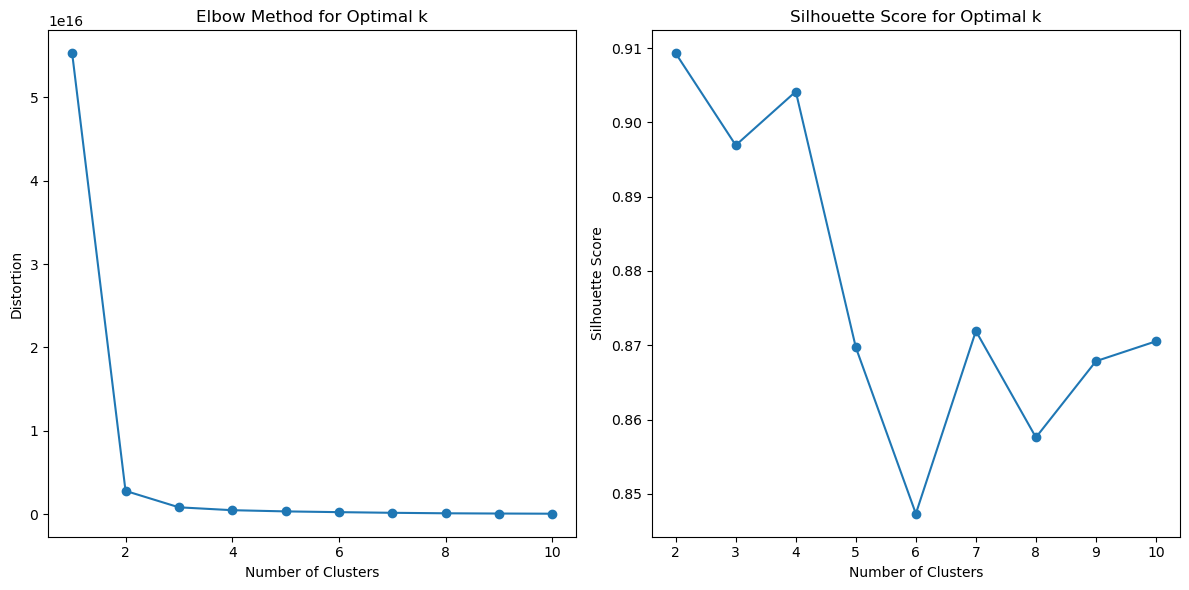

In [9]:
plot_elbow_silhouette(X = df_faulty.values, subsample_size=10000) 

In [ ]:
model_dbscan = tune_dbscan(df_faulty.values)

In [ ]:
model_dbscan

In [ ]:
cluster_labels, dbscan_min_max_scaler = visualize_dbscan(df_faulty.values, model_dbscan, visualization_method='scatter_3d')

In [ ]:
joblib.dump(model_dbscan, 'models/dbscan.joblib')

In [ ]:
np.save('models/cluster_labels.npy', cluster_labels)

In [ ]:
joblib.dump(dbscan_min_max_scaler, 'models/dbscan_minmax_scaler.joblib')

In [ ]:
cluster_labels.shape

In [ ]:
df_faulty.to_csv('results/faulty_data_predicted_elliptic_last_two_months.csv')